**UBER COMMENTS SENTIMENT ANALYSIS**

Table of content

1. **DATA PREPARATION**
- check data consistency
- removing all useless characters
- data optimization (dimensionality reduction)

2. **SENTIMENT ANALYSIS**
- vader score computation
- classification

3. **LOGISTIC REGRESSION**
- baseline model 
- hyperparameter tuning

4. **INTERPRETATION AND ANALYSIS**
- sentiment distribution
- sentiment VS time
- sentiment VS hour of a day
- Explaining sentiment : What stands out of the comments ? 
- Explaining sentiment : What made people so satisfied in early December ? 



In [109]:
from tqdm import tqdm
import numpy as np
import pandas as pd
from itertools import accumulate
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from scipy.stats import uniform, loguniform

import string
import re

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import wordnet

nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')

from xgboost import XGBClassifier
import xgboost as xgb

from collections import Counter
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/gabin/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/gabin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/gabin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/gabin/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/gabin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [110]:
df = pd.read_csv('uber_reviews_without_reviewid.csv.xls')
df.head(10)

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,User_0,NaN,Good,5,0,4.556.10005,2024-12-18 17:17:19,NaN,NaN,4.556.10005
1,User_1,NaN,Nice,5,0,4.556.10005,2024-12-18 17:17:17,NaN,NaN,4.556.10005
2,User_2,NaN,Very convenient,5,0,4.532.10001,2024-12-18 17:09:42,NaN,NaN,4.532.10001
3,User_3,NaN,Good,4,0,4.556.10005,2024-12-18 17:08:27,NaN,NaN,4.556.10005
4,User_4,NaN,exllence,5,0,4.556.10005,2024-12-18 17:08:16,NaN,NaN,4.556.10005
5,User_5,NaN,Michelle was a very friendly and personable pe...,5,0,4.556.10005,2024-12-18 17:06:09,NaN,NaN,4.556.10005
6,User_6,NaN,Bast price pr car available,5,0,4.556.10005,2024-12-18 17:06:04,NaN,NaN,4.556.10005
7,User_7,NaN,Good service,5,0,4.556.10005,2024-12-18 17:05:20,NaN,NaN,4.556.10005
8,User_8,NaN,Awesome,5,0,4.556.10005,2024-12-18 17:05:10,NaN,NaN,4.556.10005
9,User_9,NaN,Nice 🙂🙂🙂🙂🙂,5,0,4.556.10005,2024-12-18 17:04:02,NaN,NaN,4.556.10005


1. **DATA PREPARATION**

DATA CONSISTENCY

Let is drop the columns we will not use 

In [111]:
df = df.drop(columns=['userImage', 'reviewCreatedVersion', 'replyContent','repliedAt', 'appVersion'])

In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   userName       12000 non-null  object
 1   content        12000 non-null  object
 2   score          12000 non-null  int64 
 3   thumbsUpCount  12000 non-null  int64 
 4   at             12000 non-null  object
dtypes: int64(2), object(3)
memory usage: 468.9+ KB


"at" record the timestamp of the comment: let is change its format from object to datetime

In [113]:
df['at'] = pd.to_datetime(df['at'])

REMOVING ALL USELESS CHARACTERS

The d_types are correct. To continue the implementation of sentiment analysis, it is necessary to put all text objects in lower case, let is do it !

In [114]:
df['new_content'] = df['content'].str.lower()
df.sample(3)

,userName,content,score,thumbsUpCount,at,new_content
8333,User_8333,Good budget friendly,5,0,2024-12-01 19:03:07,good budget friendly
6329,User_6329,"The worst cab app , i booked bike and he took ...",1,0,2024-12-05 08:46:23,"the worst cab app , i booked bike and he took ..."
10982,User_10982,Most awful horrible company you can't get a ho...,1,0,2024-11-26 21:28:05,most awful horrible company you can't get a ho...


To handle misinterpretation issues, it is intersteing to transform formulation with negation to "positive affirmation"
 (I am not very happy -> I am unhappy) Without doing this  "happy" would have been considered as a positive word and corrupt the sentiment of the comment.

In [115]:
def negate(sentence):
    temp = int(0)
    for i in range(len(sentence)):
        if sentence[i-1] in ['not',"n't"]:
            antonyms = []
            for syn in wordnet.synsets(sentence[i]):
                syns = wordnet.synsets(sentence[i])
                w1 = syns[0].name()
                temp = 0
                for l in syn.lemmas():
                    if l.antonyms():
                        antonyms.append(l.antonyms()[0].name())
                        max_dissimilarity = 0
                        for ant in antonyms:
                            syns = wordnet.synsets(ant)
                            w2 = syns[0].name()
                            syns = wordnet.synsets(sentence[i])
                            w1 = syns[0].name()
                            word1 = wordnet.synset(w1)
                            word2 = wordnet.synset(w2)
                            if isinstance(word1.wup_similarity(word2), float) or isinstance(word1.wup_similarity(word2), int):
                                temp = 1 - word1.wup_similarity(word2)
                                if temp>max_dissimilarity:
                                    max_dissimilarity = temp
                                    antonym_max = ant
                                    sentence[i] = antonym_max
                                    sentence[i-1] = ''
    while '' in sentence:
        sentence.remove('')
    return sentence

Now that the fonction is defined, let is apply it to our content

In [116]:
df['new_content'] = df['new_content'].apply(lambda x: negate(word_tokenize(x)))
df.head(5)

,userName,content,score,thumbsUpCount,at,new_content
0,User_0,Good,5,0,2024-12-18 17:17:19,[good]
1,User_1,Nice,5,0,2024-12-18 17:17:17,[nice]
2,User_2,Very convenient,5,0,2024-12-18 17:09:42,"[very, convenient]"
3,User_3,Good,4,0,2024-12-18 17:08:27,[good]
4,User_4,exllence,5,0,2024-12-18 17:08:16,[exllence]


In order to apply negate function we had to tokenize the content. Since it not necessary anymore, let is  unlist eevrything

In [117]:
def unlist(list):
    words=''
    for item in list:
        words+=item+' '
    return words

In [118]:
df['new_content'] = df['new_content'].apply(lambda x: unlist(x))
df.head()

,userName,content,score,thumbsUpCount,at,new_content
0,User_0,Good,5,0,2024-12-18 17:17:19,good
1,User_1,Nice,5,0,2024-12-18 17:17:17,nice
2,User_2,Very convenient,5,0,2024-12-18 17:09:42,very convenient
3,User_3,Good,4,0,2024-12-18 17:08:27,good
4,User_4,exllence,5,0,2024-12-18 17:08:16,exllence


The contents are full of punctuations that will not be useful to our analysis. Let is delete them.

In [119]:
punc = string.punctuation
print("The punctuation signs in Python are: " + punc)

def delete_punc(text):
    text_wo_punc = text.translate(str.maketrans("", "", punc))
    return text_wo_punc

The punctuation signs in Python are: !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [120]:
df['new_content'] = df['new_content'].apply(lambda text: delete_punc(text))
df.head(2)

,userName,content,score,thumbsUpCount,at,new_content
0,User_0,Good,5,0,2024-12-18 17:17:19,good
1,User_1,Nice,5,0,2024-12-18 17:17:17,nice


Then we can remove "banal" or "neutral" words that does not bring anything to the sentiment analysis

In [121]:
print("The stopwords in English are: ")
", ".join(stopwords.words("english"))

to_stop = set(stopwords.words("english"))

def delete_stopwords(text):
    # tokenize words in text
    word_tokens = word_tokenize(text)
    removed = [word for word in word_tokens if not word in to_stop]
    new_text = " ".join(removed)
    return new_text

The stopwords in English are: 


In [122]:
df['new_content'] = df['new_content'].apply(lambda text: delete_stopwords(text))
df.sample(1, random_state = 2024)

,userName,content,score,thumbsUpCount,at,new_content
3835,User_3835,Good 👍,5,0,2024-12-10 13:06:49,good 👍


Then, we can find in the content : numbers, url or email. These pieces of text are also useless and should not corrupt the analysis so let is remove them

In [123]:
def remove_num_url_email(text):
    text = re.sub('@[^\s]+', ' ', text)
    text = re.sub("((http:\/\/www\.)|(www\.)|(http:\/\/))[a-zA-Z0-9._-]+\.[a-zA-Z.]{2,5}", "", text)
    text = re.sub('[0-9]+', '', text)
    return text

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\/'
<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\/'
/var/folders/xk/_lxyx6nn61b0nzyx5vp0p0ph0000gn/T/ipykernel_80109/3091105778.py:2: SyntaxWarning: invalid escape sequence '\s'
  text = re.sub('@[^\s]+', ' ', text)
/var/folders/xk/_lxyx6nn61b0nzyx5vp0p0ph0000gn/T/ipykernel_80109/3091105778.py:3: SyntaxWarning: invalid escape sequence '\/'
  text = re.sub("((http:\/\/www\.)|(www\.)|(http:\/\/))[a-zA-Z0-9._-]+\.[a-zA-Z.]{2,5}", "", text)


In [124]:
df['new_content'] = df['new_content'].apply(lambda x: remove_num_url_email(x))
df.tail(2)

,userName,content,score,thumbsUpCount,at,new_content
11998,User_11998,Good Service.,5,0,2024-11-24 21:50:30,good service
11999,User_11999,"Very bad experience with this app, booked a sh...",1,0,2024-11-24 21:44:44,bad experience app booked short ride rs unwant...


DATA OPTIMIZATION (dimensionality reduction)

At this point we have deleted all useless content in the comments. Let is now work on the core of the messages. We will first use **lemmatization** before **stemming** in order to reduce dimmensionality of the content focusing on the key sentiment rather than singular way to express them.
To do so, we first need to tokenize the content so we are able isolate individual words and process them.

Tokenisation

In [125]:
tokenizer = RegexpTokenizer(r'\w+')
df['new_content'] = df['new_content'].apply(tokenizer.tokenize)
df.head(2)

,userName,content,score,thumbsUpCount,at,new_content
0,User_0,Good,5,0,2024-12-18 17:17:19,[good]
1,User_1,Nice,5,0,2024-12-18 17:17:17,[nice]


Lemmatization

In [126]:
lemm = nltk.WordNetLemmatizer()
def lemmatize_text(text):
    newtext = [lemm.lemmatize(word) for word in text]
    return text

df['new_content'] = df['new_content'].apply(lambda x: lemmatize_text(x))
df.head(2)

,userName,content,score,thumbsUpCount,at,new_content
0,User_0,Good,5,0,2024-12-18 17:17:19,[good]
1,User_1,Nice,5,0,2024-12-18 17:17:17,[nice]


stemming

In [127]:
stem = nltk.PorterStemmer()
def stem_text(text):
    stemmed = [stem.stem(word) for word in text]
    return stemmed

df['new_content']= df['new_content'].apply(lambda x: stem_text(x))
df.tail(5)

,userName,content,score,thumbsUpCount,at,new_content
11995,User_11995,Excellent!!!,5,0,2024-11-24 21:59:16,[excel]
11996,User_11996,Worst experience after 10pm in Hyde cityno aut...,5,0,2024-11-24 21:56:10,"[worst, experi, pm, hyde, cityno, auto, take, ..."
11997,User_11997,Exceptional,5,0,2024-11-24 21:52:21,[except]
11998,User_11998,Good Service.,5,0,2024-11-24 21:50:30,"[good, servic]"
11999,User_11999,"Very bad experience with this app, booked a sh...",1,0,2024-11-24 21:44:44,"[bad, experi, app, book, short, ride, rs, unwa..."


I will rename the new columns for more clarity (probably should have done it before)

In [128]:
df.rename(columns = {'content': 'original_content', 
                     'new_content': 'content_lst'}, inplace = True)
df.tail()

,userName,original_content,score,thumbsUpCount,at,content_lst
11995,User_11995,Excellent!!!,5,0,2024-11-24 21:59:16,[excel]
11996,User_11996,Worst experience after 10pm in Hyde cityno aut...,5,0,2024-11-24 21:56:10,"[worst, experi, pm, hyde, cityno, auto, take, ..."
11997,User_11997,Exceptional,5,0,2024-11-24 21:52:21,[except]
11998,User_11998,Good Service.,5,0,2024-11-24 21:50:30,"[good, servic]"
11999,User_11999,"Very bad experience with this app, booked a sh...",1,0,2024-11-24 21:44:44,"[bad, experi, app, book, short, ride, rs, unwa..."


Just as before let is unlist everything after the tokenization as we finsihed processing the data.

In [129]:
df['content_nlst'] = df['content_lst'].apply(lambda x: unlist(x))
df.tail()

,userName,original_content,score,thumbsUpCount,at,content_lst,content_nlst
11995,User_11995,Excellent!!!,5,0,2024-11-24 21:59:16,[excel],excel
11996,User_11996,Worst experience after 10pm in Hyde cityno aut...,5,0,2024-11-24 21:56:10,"[worst, experi, pm, hyde, cityno, auto, take, ...",worst experi pm hyde cityno auto take ride
11997,User_11997,Exceptional,5,0,2024-11-24 21:52:21,[except],except
11998,User_11998,Good Service.,5,0,2024-11-24 21:50:30,"[good, servic]",good servic
11999,User_11999,"Very bad experience with this app, booked a sh...",1,0,2024-11-24 21:44:44,"[bad, experi, app, book, short, ride, rs, unwa...",bad experi app book short ride rs unwant unnam...


2. **SENTIMENT ANALYSIS**

Now that the data is ready we proceed to the sentiment analysis. To do so it is preferabel to work on a differneet DataFrame and the add the final result of the analysis to the orginal dataframe. 


VADER SCORE COMPUTATIONS

First, let is compute the vader scores indicating how much a comment is positve, neutral or negative.

In [130]:
vaderScores = pd.DataFrame()
vaderScores['original_content'] = df['original_content']
vaderScores['content'] = df['content_nlst']

def compute_vader_scores(df, label):
    sid = SentimentIntensityAnalyzer()
    df["vader_neg"] = df[label].apply(lambda x: sid.polarity_scores(x)["neg"])
    df["vader_neu"] = df[label].apply(lambda x: sid.polarity_scores(x)["neu"])
    df["vader_pos"] = df[label].apply(lambda x: sid.polarity_scores(x)["pos"])
    df["vader_comp"] = df[label].apply(lambda x: sid.polarity_scores(x)["compound"])
    return df

vaderScores = compute_vader_scores(vaderScores,'content')
vaderScores.sample(3, random_state = 2)

,original_content,content,vader_neg,vader_neu,vader_pos,vader_comp
7104,Good,good,0.0,0.000,1.000,0.4404
5878,Good,good,0.0,0.000,1.000,0.4404
7311,Best service,best servic,0.0,0.192,0.808,0.6369


CLASSIFICATION

**vader_comp** corresponds to the ponderated sum of all scores giving insights on the sentiment of the comment.

Based on the previous result it is now possible to classify every comment : 

- vader_comp between -1 and -0,05 -> **negative**
- vader_comp between -0,05 and 0,05 -> **neutral**
- vader_comp between 0,05 and 1 -> **positive**

In [131]:
vaderScores['target'] = np.where(vaderScores['vader_comp'] >= 0.05, 1, np.where(vaderScores['vader_comp'] <= -0.05, -1, 0))
vaderScores.sample(3, random_state = 2)

,original_content,content,vader_neg,vader_neu,vader_pos,vader_comp,target
7104,Good,good,0.0,0.000,1.000,0.4404,1
5878,Good,good,0.0,0.000,1.000,0.4404,1
7311,Best service,best servic,0.0,0.192,0.808,0.6369,1


We can finally add the new column sentiment to the orginal dataset

In [132]:
df['sentiment'] = vaderScores['target']
df.sample(3, random_state = 2)

,userName,original_content,score,thumbsUpCount,at,content_lst,content_nlst,sentiment
7104,User_7104,Good,5,0,2024-12-03 20:32:11,[good],good,1
5878,User_5878,Good,5,0,2024-12-06 07:29:11,[good],good,1
7311,User_7311,Best service,5,0,2024-12-03 12:55:11,"[best, servic]",best servic,1


3. **LOGISTIC REGRESSION**

We could have stopped here and and started out analysis but let is take advantage of our new datatset to perform a logistic regression with XGBoost Classifier. 

Let is start by split and vectorize the data to fit the requirements from XGboost classifier.

In [133]:
X = df['content_nlst']
y = df['sentiment']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,stratify=df['sentiment'], random_state=24) 

# Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words = 'english')
X_train_vec = tfidf_vectorizer.fit_transform(X_train)
X_test_vec = tfidf_vectorizer.transform(X_test)

In [134]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [135]:
vader = SentimentIntensityAnalyzer()

# Perform sentiment analysis using VADER on the training set
train_sent = [vader.polarity_scores(text)['compound'] for text in X_train]

# Convert the sentiment scores to target labels: 1 is positive, 0 is neutral, -1 is negative:
train_pred = [1 if score >= 0.05 else -1 if score <= -0.05 else 0 for score in train_sent]

BASELINE MODEL

In [136]:
xgbc = XGBClassifier(max_depth=5, n_estimators = 1000, nthread = 3)
xgbc.fit(X_train_vec, y_train_encoded)
prediction_xgb = xgbc.predict(X_test_vec)
print(f"Accuracy: {accuracy_score(prediction_xgb, y_test_encoded):.2%}")

Accuracy: 93.86%


An accuracy of 93,9% is already pretty satisfying but let is see how much we can improve it.

HYPERPARAMETERS TUNNING

Let is try to imporve accuracy by testing randomly different hyperparameters "composition" using RandomizedSearchCV
For a cleaner test we wil use pipeline 

In [137]:
cpu_count = multiprocessing.cpu_count()
# define the range of hyperparameters we are likely to test
param_dist = {"classifier__learning_rate": uniform(0.000001, 0.3),
              "classifier__max_depth": range(2,5),
              "classifier__n_estimators": range(500,1001),
              "classifier__min_child_weight": loguniform(1,5),
              "classifier__max_delta_step": range(0,11)
             }

#define the pipeline
classifier = XGBClassifier(n_jobs=cpu_count, seed=2024)
model_pipeline  = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, stop_words = 'english')),
    ('classifier', classifier)
])

#test random "composition" of hyperparameters
rs = RandomizedSearchCV(model_pipeline, scoring='accuracy',
                        param_distributions=param_dist,
                        n_iter=25, n_jobs=1, random_state=2024, verbose=2)

rs.fit(X_train, y_train_encoded)

# Get and store the best hyperparameters
model_params = {'n_jobs':cpu_count, 'seed':2024}
best_params = {x.split('__')[1]:rs.best_params_[x] for x in rs.best_params_}
model_params.update(best_params)
model = XGBClassifier(**model_params)
model.fit(X_train_vec, y_train_encoded)
predictions=model.predict(X_test_vec)

print('Accuracy: ', round(accuracy_score(y_test_encoded, predictions)*100,2), '%')

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END classifier__learning_rate=0.17640535566861937, classifier__max_delta_step=0, classifier__max_depth=2, classifier__min_child_weight=1.3536692897350402, classifier__n_estimators=946; total time=   3.4s
[CV] END classifier__learning_rate=0.17640535566861937, classifier__max_delta_step=0, classifier__max_depth=2, classifier__min_child_weight=1.3536692897350402, classifier__n_estimators=946; total time=   3.0s
[CV] END classifier__learning_rate=0.17640535566861937, classifier__max_delta_step=0, classifier__max_depth=2, classifier__min_child_weight=1.3536692897350402, classifier__n_estimators=946; total time=   3.0s
[CV] END classifier__learning_rate=0.17640535566861937, classifier__max_delta_step=0, classifier__max_depth=2, classifier__min_child_weight=1.3536692897350402, classifier__n_estimators=946; total time=   3.0s
[CV] END classifier__learning_rate=0.17640535566861937, classifier__max_delta_step=0, classifier__max_

We managed to improve the accuracy to 95% wich is very satisfying !

4. **INTERPRETATION AND ANALYSIS**

In [138]:
df['sentiment'].value_counts()

sentiment
 1    7619
 0    2651
-1    1730
Name: count, dtype: int64

In [139]:
vaderScores.describe()

,vader_neg,vader_neu,vader_pos,vader_comp,target
count,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000
mean,0.054406,0.458620,0.475390,0.246269,0.490750
std,0.142338,0.376102,0.408828,0.398420,0.733684
min,0.000000,0.000000,0.000000,-0.970900,-1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.408000,0.511000,0.421500,1.000000
75%,0.000000,0.807000,0.857000,0.458800,1.000000
max,1.000000,1.000000,1.000000,0.979700,1.000000


SENTIMENT DISTRIBUTION

/var/folders/xk/_lxyx6nn61b0nzyx5vp0p0ph0000gn/T/ipykernel_80109/4022168958.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=df, palette='Purples')


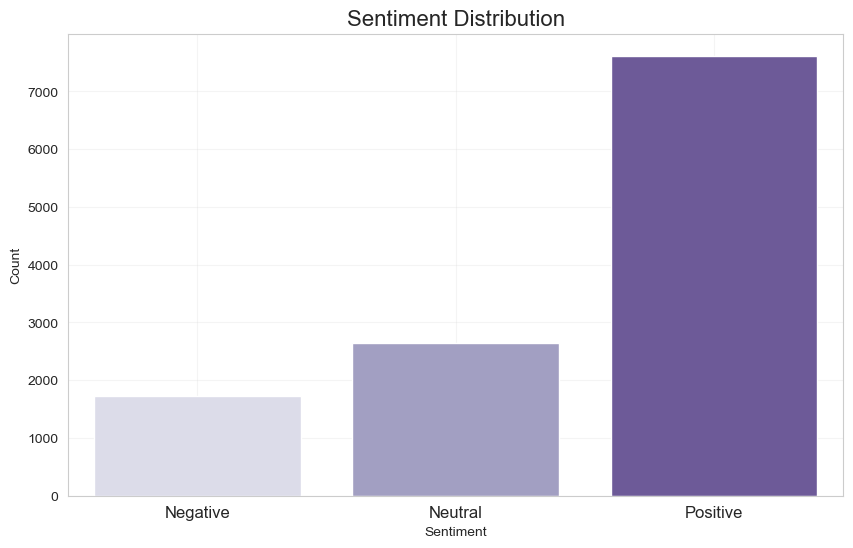

In [140]:
# Create the bar plot
sns.set_style('whitegrid')
plt.figure(figsize=(10, 6))
sns.countplot(x='sentiment', data=df, palette='Purples')

# Customize the plot
plt.title('Sentiment Distribution', fontsize=16)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(ticks = [0,1,2], labels=['Negative', 'Neutral', 'Positive'], fontsize=12)
plt.grid(alpha = 0.2)

plt.show()


Great news for Uber, the overall comments are positive !


But let is try to go deeper in the analysis using the vader_comp score to visualize the 'intensity' of the sentiment. How positive are positive commments ?

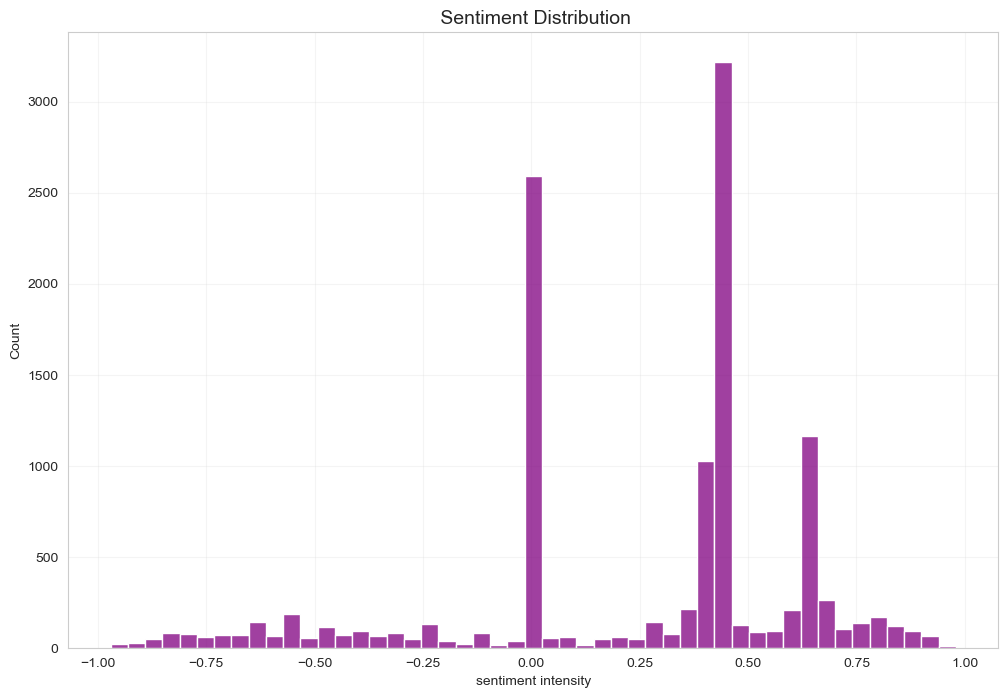

In [141]:
# Create the histogram
sns.set_style('whitegrid')
plt.figure(figsize=(12, 8))
sns.histplot(x=vaderScores['vader_comp'], color='Purple')

#customize it
plt.title(' Sentiment Distribution', fontsize=14)
plt.xlabel('sentiment intensity')
plt.grid(alpha=0.2)

plt.show()

We understand here that the satisfaction is pretty moderated, uber consumer being mostly neutral or pretty satisfied about the service. Let is try to have more insights by looking at the distribution for each category 

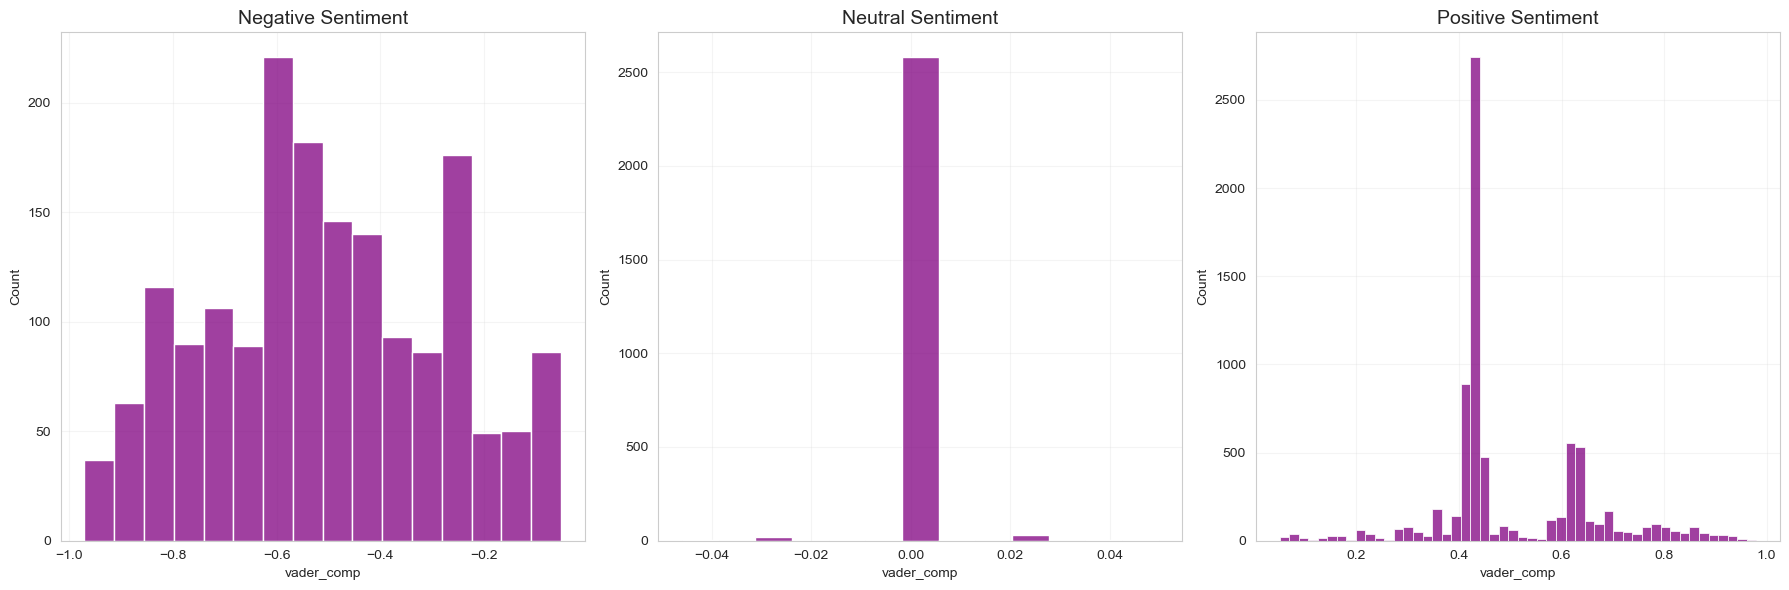

In [142]:
# Create the visual
sns.set_style('whitegrid')
plt.figure(figsize=(18, 6))

# Subplot for positive comments
plt.subplot(1, 3, 3)  
positive_comments = vaderScores[vaderScores['vader_comp'] >= 0.05]
sns.histplot(x=positive_comments['vader_comp'], color='Purple')
plt.title('Positive Sentiment', fontsize=14)
plt.grid(alpha=0.2)

# Subplot for negative comments
plt.subplot(1, 3, 1)  
negative_comments = vaderScores[vaderScores['vader_comp'] <= -0.05]
sns.histplot(x=negative_comments['vader_comp'], color='Purple')
plt.title('Negative Sentiment', fontsize=14)
plt.grid(alpha=0.2)

# Subplot for neutral comments
plt.subplot(1, 3, 2)  
neutral_comments = vaderScores[(vaderScores['vader_comp'] > -0.05) & (vaderScores['vader_comp'] < 0.05)]
sns.histplot(x=neutral_comments['vader_comp'], color='Purple')
plt.title('Neutral Sentiment', fontsize=14)
plt.grid(alpha=0.2)

# Show the plot
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


We can observe that negative comment are more or less normally distributed. Just like positive comments, the instensity is moderated with a minority of extreme values. 

SENTIMENT OVER TIME

Before starting our analysis, it is necesseary to adaprt the target column for more readability of the visuals. Let is use on ecolumn for the day and another for the hour 

In [143]:
df['date'] = df['at'].dt.date
df['hour'] = df['at'].dt.hour

First let is try to see if there are any significant evolutions of the sentiment between the end of November and mid December : the period of time under analysis

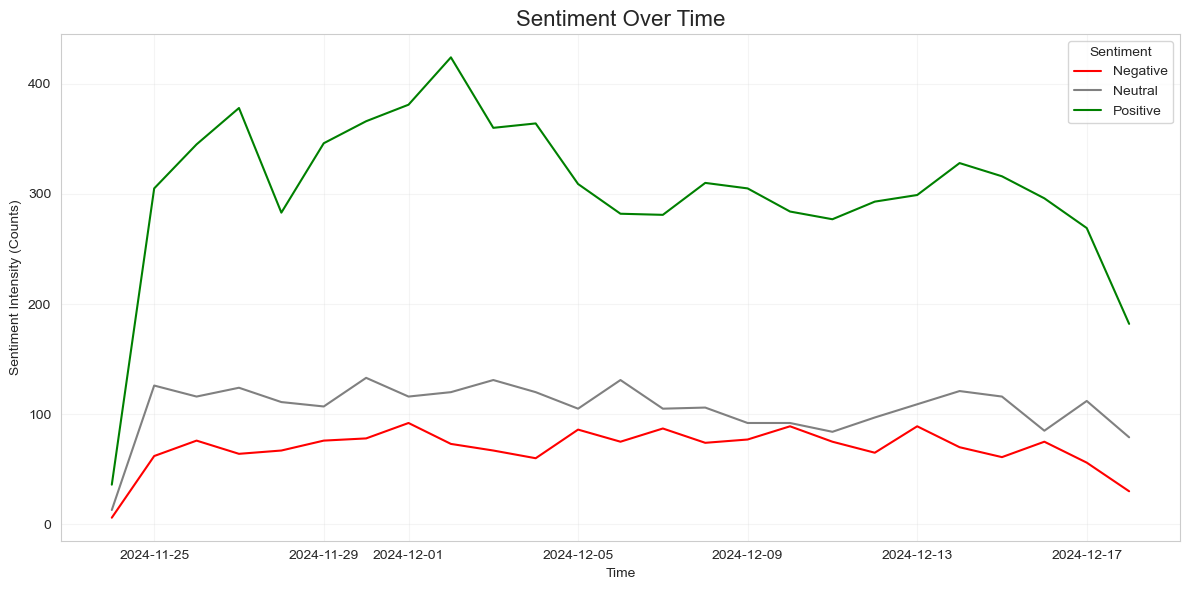

In [144]:
# Group the data by date and sentiment to get the count of each sentiment over time
df_grouped = df.groupby(['date', 'sentiment']).size().reset_index(name='counts')

# Cretate the visual
sns.set_style('whitegrid')
plt.figure(figsize=(12, 6))

# Plot the negative sentiment over time
sns.lineplot(x='date', y='counts', data=df_grouped[df_grouped['sentiment'] == -1], label='Negative', color='red')

# Plot the neutral sentiment over time
sns.lineplot(x='date', y='counts', data=df_grouped[df_grouped['sentiment'] == 0], label='Neutral', color='grey')

# Plot the positive sentiment over time
sns.lineplot(x='date', y='counts', data=df_grouped[df_grouped['sentiment'] == 1], label='Positive', color='green')

# Customize the plot
plt.title('Sentiment Over Time', fontsize=16)
plt.xlabel('Time')
plt.ylabel('Sentiment Intensity (Counts)')
plt.legend(title='Sentiment')
plt.grid(alpha=0.2)

# Display the plot
plt.tight_layout()
plt.show()

It seems that between Dcember 1st and 3rd people were particularly satisfied about their ride ! We will try to understand why in the last section of this analysis.

SENTIMENT OVER THE DAY 

Are there any patterns in the evolution of the sentiments throughout the day ? 

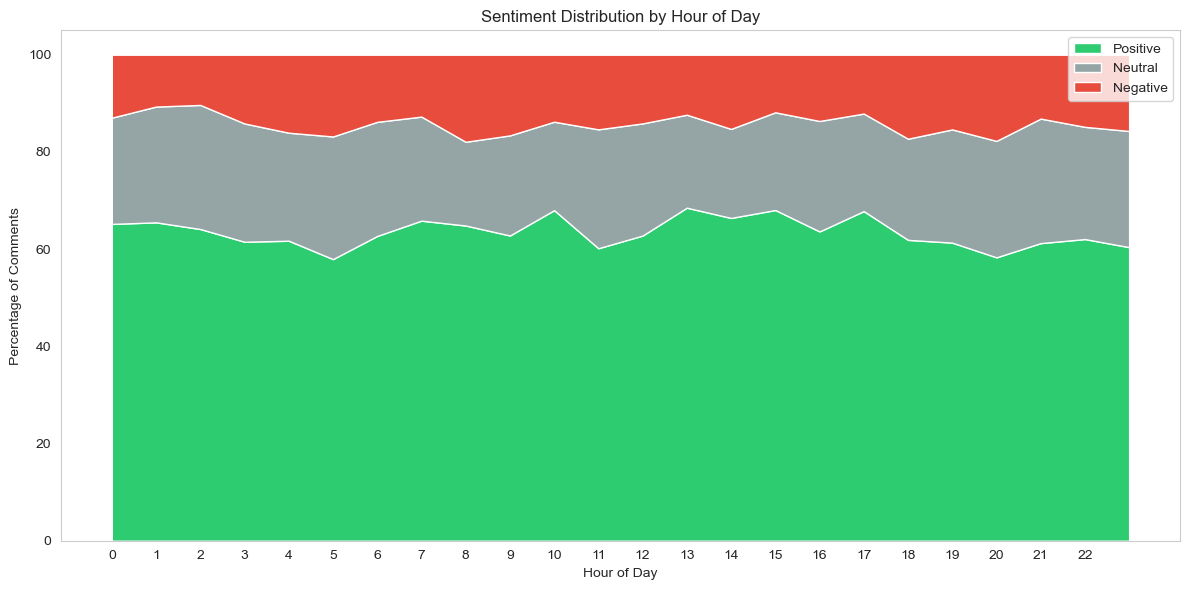

In [145]:
# Calculate percentage of each sentiment for each hour
sentiment_by_hour = pd.DataFrame()
total_by_hour = df.groupby('hour').size()
for sentiment, label in zip([1, 0, -1], ['Positive', 'Neutral', 'Negative']):
    sentiment_counts = df[df['sentiment'] == sentiment].groupby('hour').size()
    sentiment_percentage = (sentiment_counts / total_by_hour * 100)
    sentiment_by_hour[label] = sentiment_percentage

# Create the stacked area plot
plt.figure(figsize=(12, 6))
plt.stackplot(sentiment_by_hour.index, 
              sentiment_by_hour['Positive'],
              sentiment_by_hour['Neutral'],
              sentiment_by_hour['Negative'],
              labels=['Positive', 'Neutral', 'Negative'],
              colors=['#2ecc71', '#95a5a6', '#e74c3c'],
              )

# Customize the plot
plt.title('Sentiment Distribution by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Percentage of Comments')
plt.legend()
plt.grid(False)

# Set x-axis ticks to show all hours
plt.xticks(range(0,23))

#print the plot
plt.tight_layout()
plt.show()

Except a slight decrease of the positive comments and increase of the negative ones between 2am and 5am, there is nothing really significant to highlight. 

WHAT EXPLAINS SENTIMENTS

Let is try now to focus on the content of both positive and negative sentiment. By retrieving for each category the most common words we may have a better understand of what caused such feelings.

We will start by the negative sentiment since it is the most concerning.

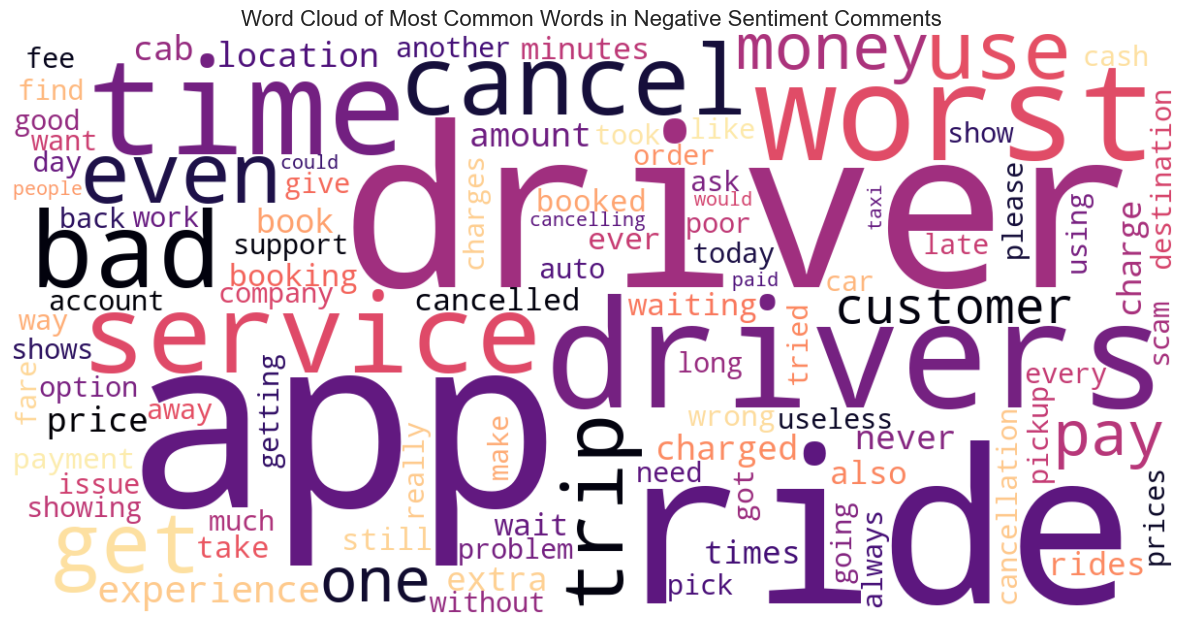

In [146]:
# Load stop words
negative_comments = df[df['sentiment'] ==-1]
stop_words = set(stopwords.words('english'))

# Exclude the word 'uber' from the stop words
stop_words.update(['uber'])

# Combine all negative comments into a single text string and tokenize
all_words = " ".join(negative_comments['original_content'].astype(str))
tokens = nltk.word_tokenize(all_words)

# Simple filtering approach
filtered_words = [
    word.lower() for word in tokens
    if word.isalpha()
    and word.lower() not in stop_words
    and len(word) > 2
]

# Generate word frequency dictionary
word_counts = dict(Counter(filtered_words))

# Create and configure word cloud
wordcloud = WordCloud(
    width=1200,
    height=600,
    background_color='white',
    colormap='magma',
    max_words=100,
).generate_from_frequencies(word_counts)

# Display the word cloud
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Most Common Words in Negative Sentiment Comments", fontsize=16)
plt.show()

We can identify different groups of words and try to "clusterize" them in order to get relevant information:
2 main problems : 
- First it appears pretty clearly that the main reason of the discontentment of people is the driver
- Then comes the app

And other one less important : 
- scams /extra fees
- paiment method
- cancellation
- Delay / waiting time 


Now what about the good points ? (which are by the way the more important in numbers)

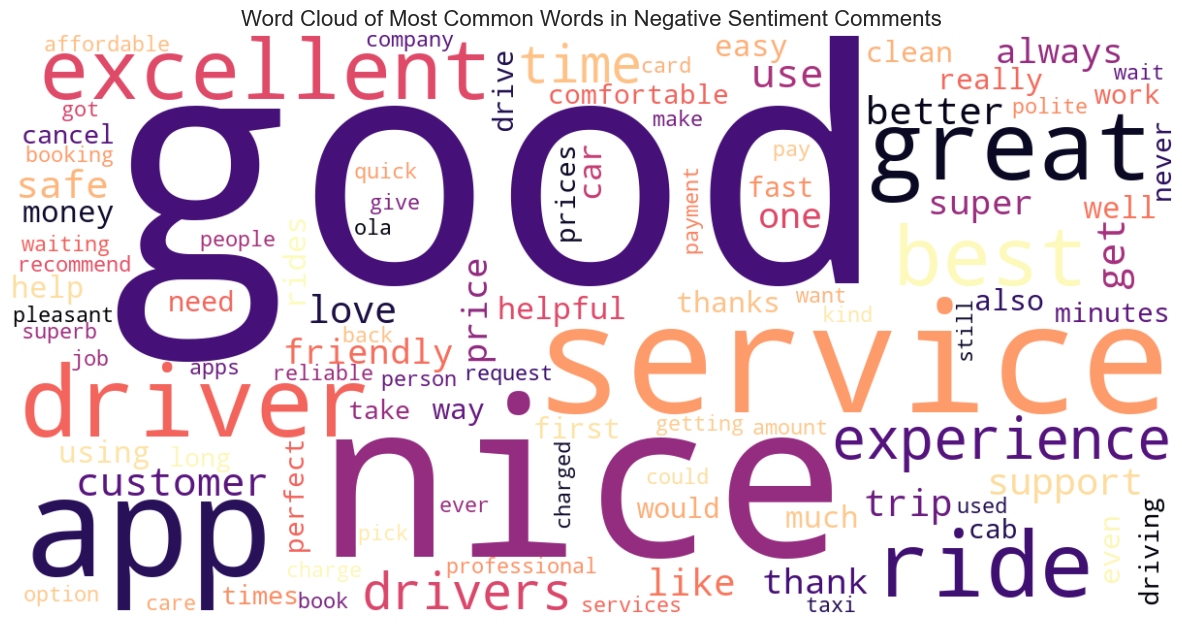

In [147]:
# Load stop words
positive_comments = df[df['sentiment'] == 1]
stop_words = set(stopwords.words('english'))

# Exclude the word 'uber' from the stop words
stop_words.update(['uber'])

# Combine all positive comments into a single text string and tokenize
all_words = " ".join(positive_comments['original_content'].astype(str))
tokens = nltk.word_tokenize(all_words)

# Simple filtering approach
filtered_words = [
    word.lower() for word in tokens
    if word.isalpha()
    and word.lower() not in stop_words
    and len(word) > 2  # Remove very short words
]

# Generate word frequency dictionary
word_counts = dict(Counter(filtered_words))

# Create and configure word cloud
wordcloud = WordCloud(
    width=1200,
    height=600,
    background_color='white',
    colormap='magma',
    max_words=100,
).generate_from_frequencies(word_counts)

# Display the word cloud
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Most Common Words in Negative Sentiment Comments", fontsize=16)
plt.show()

What is striking here is the number of adjectives. People that had a nice trip tend to focus on their feelings more than what explains it.
However, we can still have a clue on what made this ride so nice : 
-  driver ( with a lot of positice adjective : nice, kind, friendly, professional , polite...)
-  app
-  support 

WHAT MADE PEPOLE SO SATISFIED IN EARLY DECEMBER

Let is come back to our previous observation and let is compare the word most retrived in this period of time to the overall most retrieved. 

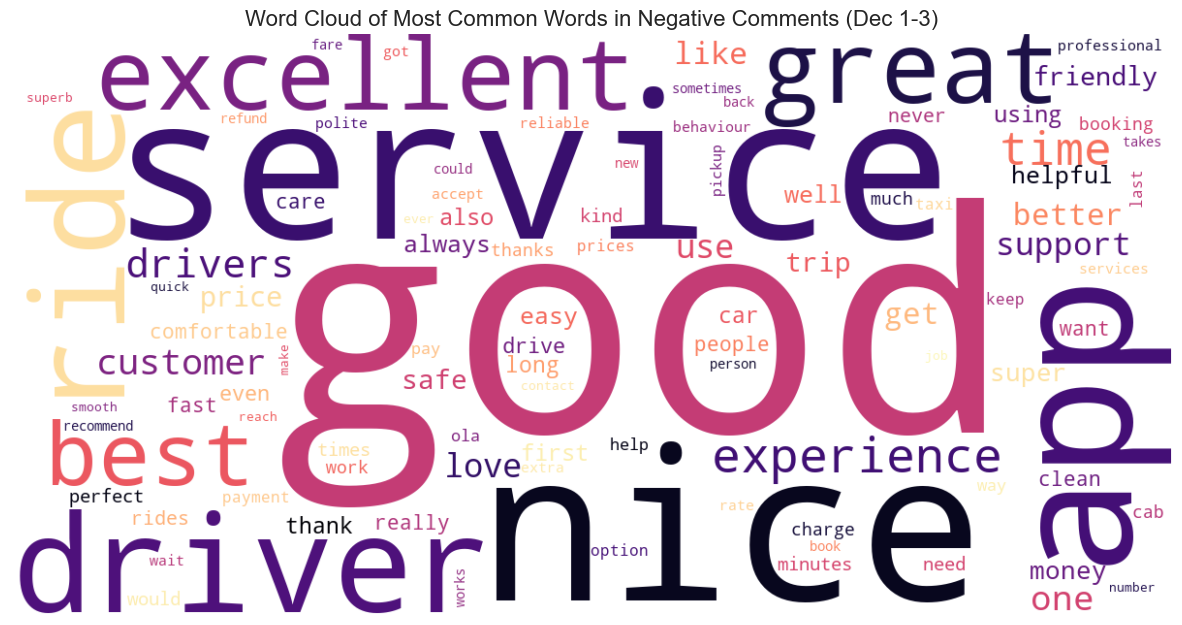

In [148]:
# Load stop words
stop_words = set(stopwords.words('english'))
stop_words.update(['uber'])
df['date'] = pd.to_datetime(df['date'])

# Filter for dates between December 1st and 3rd
date_mask = (df['date'] >= '2024-12-01') & (df['date'] <= '2024-12-03')
date_filtered_df = df[date_mask]

# Filter negative sentiment comments
positive_comments = date_filtered_df[date_filtered_df['sentiment'] == 1]

# Combine all negative comments into a single text string and tokenize
all_words = " ".join(positive_comments['original_content'].astype(str))
tokens = nltk.word_tokenize(all_words)

# Simple filtering approach
filtered_words = [
    word.lower() for word in tokens
    if word.isalpha()
    and word.lower() not in stop_words
    and len(word) > 2  # Remove very short words
]

# Generate word frequency dictionary
word_counts = dict(Counter(filtered_words))

# Create and configure word cloud
wordcloud = WordCloud(
    width=1200,
    height=600,
    background_color='white',
    colormap='magma',
    max_words=100,
).generate_from_frequencies(word_counts)

# Display the word cloud
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Most Common Words in Negative Comments (Dec 1-3)", fontsize=16)
plt.show()

Unfortunately, there is not much here to cocnlude since thhe period of time is relatively short and as mentionned previously, satisfied customer tend to focus on emotions. We can however notice a slight increase in the importance of the driver which confirms our previous conclusions : the driver is the main determinant of customer satisfaction.